<a href="https://colab.research.google.com/github/JackRakham/Image-segmentation-pytorch/blob/main/Image_segmentation_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Enviroment setup

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-2u80dtwc
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-2u80dtwc
  Resolved https://github.com/albumentations-team/albumentations to commit bb6a6fa29f3bc259869bba6742ca8cc6087a00c1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


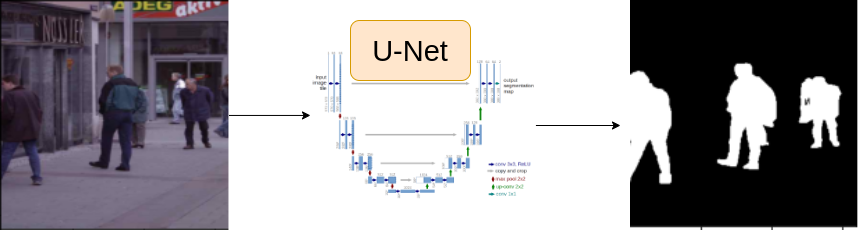

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# 2. Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOHCS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.loc[4]

image_path = row.images
mask_path = row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


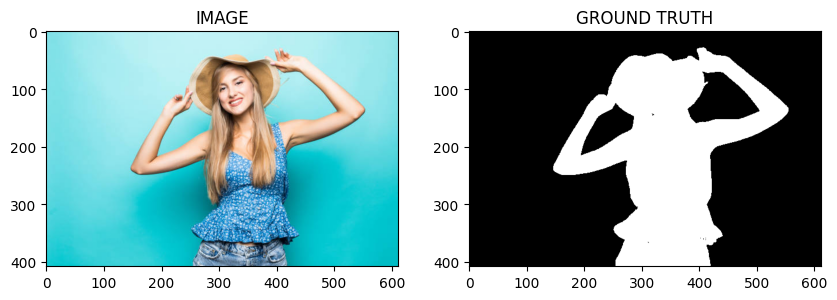

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
traind_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# 3. Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A


In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ], is_check_shapes=False)

# 4. Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data["image"]
      mask = data["mask"]

    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) /255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(traind_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [ ]:
idx = 3
image, masl = trainset[idx]

# 5. Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainLoader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validLoader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainLoader)}")
print(f"Total no. of batches in validloader : {len(validLoader)}")

Total no. of batches in trainloader : 15
Total no. of batches in validloader : 4


In [ ]:
for image, mask in trainLoader:
  break
print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# 6. Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weight = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1 + loss2
    return logits

In [ ]:
model = SegmentationModel()

model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# 7. Train and Validation Functions

In [ ]:
def train_fn(data_loader, model, optimizer ):
  model.train()

  total_loss = 0.0

  for images, masks in tqdm(data_loader):


    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model ):
  model.eval()
  total_loss = 0.0


  with torch.no_grad():
    for images, masks in tqdm(data_loader):


      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images,masks)

      total_loss += loss.item()

    return total_loss / len(data_loader)

# 8. Training

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.inf

for i in range(EPOHCS):

  train_loss = train_fn(trainLoader, model, optimizer)
  valid_loss = eval_fn(validLoader, model)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), "best_model.pth")
    print("SAVED-MODEL ")

  print(f"Epoch : {i+1} Train loss: {train_loss} Valid loss: {valid_loss}")

100%|██████████| 4/4 [00:15<00:00,  3.83s/it]


SAVED-MODEL 
Epoch : 1 Train loss: 0.7395811140537262 Valid loss: 2.215574026107788


100%|██████████| 4/4 [00:15<00:00,  3.86s/it]


SAVED-MODEL 
Epoch : 2 Train loss: 0.3529356261094411 Valid loss: 0.3071962967514992


100%|██████████| 4/4 [00:16<00:00,  4.02s/it]


SAVED-MODEL 
Epoch : 3 Train loss: 0.32136067748069763 Valid loss: 0.3058062009513378


100%|██████████| 4/4 [00:15<00:00,  3.77s/it]


SAVED-MODEL 
Epoch : 4 Train loss: 0.2906937072674433 Valid loss: 0.23586254194378853


100%|██████████| 4/4 [00:15<00:00,  3.76s/it]


Epoch : 5 Train loss: 0.2659453421831131 Valid loss: 0.2709624208509922


100%|██████████| 4/4 [00:14<00:00,  3.75s/it]


SAVED-MODEL 
Epoch : 6 Train loss: 0.23570034404595694 Valid loss: 0.19588737934827805


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]


Epoch : 7 Train loss: 0.18209793865680696 Valid loss: 0.22694848105311394


100%|██████████| 4/4 [00:15<00:00,  3.86s/it]


Epoch : 8 Train loss: 0.1469290092587471 Valid loss: 0.20797383040189743


100%|██████████| 4/4 [00:15<00:00,  3.78s/it]


Epoch : 9 Train loss: 0.1654144470890363 Valid loss: 0.20569279417395592


100%|██████████| 4/4 [00:15<00:00,  3.83s/it]


Epoch : 10 Train loss: 0.1751838634411494 Valid loss: 0.22805536910891533


100%|██████████| 4/4 [00:15<00:00,  3.81s/it]


Epoch : 11 Train loss: 0.14412311514218648 Valid loss: 0.23585528507828712


100%|██████████| 4/4 [00:14<00:00,  3.75s/it]


Epoch : 12 Train loss: 0.14924342036247254 Valid loss: 0.26731764152646065


100%|██████████| 4/4 [00:14<00:00,  3.75s/it]


Epoch : 13 Train loss: 0.14351614266633989 Valid loss: 0.2659211866557598


100%|██████████| 4/4 [00:15<00:00,  3.78s/it]


Epoch : 14 Train loss: 0.1632866606116295 Valid loss: 0.22211964800953865


100%|██████████| 4/4 [00:15<00:00,  3.79s/it]


Epoch : 15 Train loss: 0.13747112701336542 Valid loss: 0.2339312508702278


100%|██████████| 4/4 [00:15<00:00,  4.00s/it]


Epoch : 16 Train loss: 0.15297312239805858 Valid loss: 0.21834129467606544


100%|██████████| 4/4 [00:15<00:00,  3.87s/it]


Epoch : 17 Train loss: 0.14986379990975063 Valid loss: 0.21246415376663208


100%|██████████| 4/4 [00:15<00:00,  3.83s/it]


Epoch : 18 Train loss: 0.14125468581914902 Valid loss: 0.20376837439835072


100%|██████████| 4/4 [00:15<00:00,  3.81s/it]


Epoch : 19 Train loss: 0.12878786971171696 Valid loss: 0.20872959308326244


 47%|████▋     | 7/15 [02:18<02:37, 19.66s/it]

# 9. Inference

In [ ]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0